<a href="https://colab.research.google.com/github/spatiallysaying/NIPS/blob/main/georef_faa_diagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip  install pandas fiona shapely pyproj rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install Wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install affine6p

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pdfminer.six

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 14 18:09:10 2022

@author: e442282
"""

from xml.etree import ElementTree
import csv
import pandas as pd
import os
from tqdm import tqdm 
import wget 


#Download FAA PDFs
'''
#Convert Metadata in XML to CSV format
#Convert XML to CSV ( filter only for Airport Diagrams)
def convert_metaxml2csv(xmlfile_path):
  # PARSE XML
  xml = ElementTree.parse(xmlfile_path)
  
  csv_file=xmlfile_path.replace('.xml','.csv')
  csvfile = open(csv_file,'w',encoding='utf-8')
  csvfile_writer = csv.writer(csvfile)

  csvfile_writer.writerow(["airport_name","icao_ident","pdf_name"])

  # FOR EACH AIRPORT
  for apt in xml.findall(".//state_code/city_name/airport_name"):    
      if(apt):       
        for node in apt.findall('.//record'):
          chart_code=node.findtext("chart_code")        
          if chart_code == 'APD':
            icao_ident =apt.attrib["icao_ident"]
            airport_name = apt.attrib["ID"]    
            pdf_name=node.findtext("pdf_name")
            csv_line = [airport_name,icao_ident,pdf_name]
            # ADD A NEW ROW TO CSV FILE
            csvfile_writer.writerow(csv_line)
  csvfile.close()  

  return csv_file
 
#Download FAA PDFs containing Airport Diagrams 
def download_airport_diagrams(xmlfile_path,src_url,target_folder):

  if not os.path.exists(target_folder):
    os.makedirs(target_folder)

  csv_file=convert_metaxml2csv(xmlfile_path)
  df=pd.read_csv(csv_file)
  #print(df.head())
  for index, row in tqdm(df.iterrows()):
    try:
      actual_name  = row['pdf_name']
      renamed_name = row['icao_ident']+'.PDF'
      target_path=os.path.join(target_folder,renamed_name)
      dowload_link = os.path.join(src_url,actual_name)

      wget.download(dowload_link,target_path)     
    except Exception:
      pass
  del df 
  
  
# import requests

# URL = "https://aeronav.faa.gov/d-tpp/2211/xml_data/d-tpp_Metafile.xml"
# response = requests.get(URL)
# open("d-tpp_Metafile.xml", "wb").write(response.content)  
 
xmlfile = 'd-tpp_Metafile.xml' 

src_url='https://aeronav.faa.gov/d-tpp/2211/'
target_folder='faa_apds'
download_airport_diagrams(xmlfile,src_url,target_folder)

wget.download('https://adip.faa.gov/publishedAirports/all-airport-data.xlsx')

# -*- coding: latin-1 -*-
import re
s = """0°25'30"S, 91°7'W"""

def compLat_Long(deg, mins, secs, comp_dir):
    return (deg + (mins / 60) + (secs / 3600)) * comp_dir

def extract_DegMinSec(data):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    new = data.replace(u'°',' ').replace('\'',' ').replace('"',' ')
    secs=0
    deg, mins, comp_dir  = new.split()  
    deg=int(deg)
    mins=float(mins)
    comp_dir=direction[comp_dir]     
    return deg, mins, secs, comp_dir 

def extract_DD(lat_lon_str):
   deg, mins, secs, comp_dir=extract_DegMinSec(lat_lon_str)
   return compLat_Long(deg, mins, secs, comp_dir)

def extract_DegMinSec_2(data):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    comp_dir=data[-1]
    data = data[:-1]
    deg, mins,secs = data.split('-')
    deg = int(deg)
    mins= int(mins)
    secs= float(secs)
    comp_dir=direction[comp_dir]     
    return deg, mins, secs, comp_dir 

def extract_DD_2(lat_lon_str):
   deg, mins, secs, comp_dir=extract_DegMinSec_2(lat_lon_str)
   return compLat_Long(deg, mins, secs, comp_dir)

xl=pd.read_excel(r'C:\SAI\IIIT_Thesis\Scripts\all-airport-data.xlsx',"Airports")
required_cols=['Facility Type','State Name', 'City','Name','ARP Latitude','ARP Longitude','Elevation','ICAO Id']
xl=xl[required_cols]
xl = xl.dropna(subset=['ICAO Id'])
xl[xl['Facility Type'] == 'AIRPORT'] 
print(xl.head(3))


xl['longitude'] = xl.apply(lambda x: extract_DD_2(x['ARP Longitude']), axis=1)
xl['latitude'] = xl.apply(lambda x: extract_DD_2(x['ARP Latitude']), axis=1)
print(xl.head())



import itertools  
from shapely.geometry import Point
import geopandas as gpd
from matplotlib import pyplot as plt


arp_gdf = gpd.GeoDataFrame( xl, geometry=gpd.points_from_xy(xl.longitude, xl.latitude),crs="EPSG:4326")
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# We restrict to South America.
ax = world[world.continent == 'North America'].plot(color='lightgray', edgecolor='white')
# We can now plot our ``GeoDataFrame``.
arp_gdf.plot(ax=ax, color='red')



arp_gdf.to_file('FAA_Airports_Metadata.geojson', driver='GeoJSON')

'''  


# -*- coding: utf-8 -*-
"""
Created on Fri Aug 12 09:32:58 2022
@author: E442282
"""
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer, LAParams, LTTextBox, LTTextLine, LTFigure, LTImage, LTChar, LTLine, LTRect,LTCurve
import cv2
import re
import math
import numpy as np
from decimal import Decimal
import shapely
from shapely.geometry import LineString, Point
from matplotlib import pyplot as plt
import pandas as pd
# from osgeo import gdal,ogr
import geopandas as gpd
from shapely.geometry import Polygon
from itertools import chain
import ntpath

pattern = re.compile(r'(\d+)\s?\°\s?(\d+)\s?(.?)(\d+)\s?\'\s?(E|W|N|S)')
# import re
s = """0°25'30"S, 91°7'W"""

def compLat_Long(deg, mins, secs, comp_dir):
    return (deg + (mins / 60) + (secs / 3600)) * comp_dir

def extract_DegMinSec(data):
    direction = {'N': 1, 'S': -1, 'E': 1, 'W': -1}
    new = data.replace(u'°', ' ').replace('\'', ' ').replace('"', ' ')
    secs = 0
    deg, mins, comp_dir = new.split()
    deg = int(deg)
    mins = float(mins)
    comp_dir = direction[comp_dir]
    return deg, mins, secs, comp_dir

def extract_DD(lat_lon_str):
    deg, mins, secs, comp_dir = extract_DegMinSec(lat_lon_str)
    return compLat_Long(deg, mins, secs, comp_dir)

# Distance between 2 points
def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

def get_intersection_point(first_lineline, second_line):
    line1 = LineString(first_lineline)
    line2 = LineString(second_line)
    int_pt = line1.intersection(line2)
    
    return int_pt

def get_closest_latlon_edge(pt,line_segments):
    edge_no = 0
    edge_dist = []
    for edge in line_segments:
        p0 = (edge['x1'], edge['y1'])
        p1 = (edge['x2'], edge['y2'])
        dist1 = distance(p0, pt)
        dist2 = distance(p1, pt)
        tup = (min(dist1, dist2), edge_no)
        edge_dist.append(tup)
        edge_no = edge_no+1
    edge_dist_np = np.array(edge_dist)
    # sortIndices using index 0 ie 'dist'
    sortIndices = np.argsort(edge_dist_np[:, 0])
    # Return minimum distance index
    return sortIndices[0]

def get_bbox(page_layout):
    # (x0, y0, x1, y1)
    return page_layout.bbox

def get_words_rects(page_layout):
    height = page_layout.height
    word_rects = []
    for element in page_layout:
        if isinstance(element, LTTextContainer):
            word = element.get_text()            
            word_list=word.split('\n')  #Handle special case              
                   
            if len(word_list)>1:
                for w in word_list:                
                    if pattern.findall(w)  :
                        w = w.strip()
                        x1, y1, x2, y2 = element.bbox
                        x1, y1, x2, y2 = x1, height-y1, x2,height-y2
                        latlon_word = {}
                        latlon_word['x1'] = x1
                        latlon_word['y1'] = y1
                        latlon_word['x2'] = x2
                        latlon_word['y2'] = y2
                        latlon_word['text'] = w
                        word_rects.append(latlon_word) 
            else:    
               
                if pattern.findall(word)  :
                    word = word.strip()
                    x1, y1, x2, y2 = element.bbox
                    x1, y1, x2, y2 = x1, height-y1, x2,height-y2
                    latlon_word = {}
                    latlon_word['x1'] = x1
                    latlon_word['y1'] = y1
                    latlon_word['x2'] = x2
                    latlon_word['y2'] = y2
                    latlon_word['text'] = word
                    word_rects.append(latlon_word)              
                    
    return word_rects


def check_overlap_with_text(page_layout,curve):
    for element in page_layout:
        if isinstance(element, LTTextContainer):
            if curve.hoverlap(element):
                return True
    
def get_line_segments(page_layout):
    height = page_layout.height
    line_segments = []
    for element in page_layout:
        if isinstance(element, LTLine):
            x1, y1 = element.pts[0]
            x2, y2 = element.pts[1]
            x1, y1, x2, y2 = x1, height-y1, x2,height-y2
            if(x1 == x2 or y1 == y2):
                if(distance((x1, y1), (x2, y2)) > 2):
                    line_segment = {}
                    line_segment['x1'] = x1
                    line_segment['y1'] = y1
                    line_segment['x2'] = x2
                    line_segment['y2'] = y2
                    line_segments.append(line_segment)
    return line_segments

def get_largest_rect(page_layout):
    '''
    rects = []
    rects_height = {}
    for element in page_layout:
        if isinstance(element, LTRect):
            rects.append(element.bbox)
    for i, rect in enumerate(rects):
        x1, y1, x2, y2 = rect
        rects_height[i] = x2-x1
    max_rect_index = max(rects_height, key=rects_height.get)
    largest_rect = rects[max_rect_index]
    # print("\nlargest_rect :",largest_rect )
    '''
    return page_layout.bbox
    #return largest_rect

def get_lat_lon_segments(page_layout, word_rects, line_segments):
    lat_segments = []
    lon_segments = []
    # print('No of lat/lon segments :', len(word_rects))
    rx1, ry1, rx2, ry2 = get_largest_rect(page_layout)
    
    for word in word_rects:
        cx, cy = (word['x1']+word['x2'])/2, (word['y1']+word['y2'])/2
        pt = (cx, cy)
        closest_edge_index = get_closest_latlon_edge(pt,line_segments)
        my_line = line_segments[closest_edge_index]
        x1, y1, x2, y2 = my_line['x1'], my_line['y1'], my_line['x2'], my_line['y2']        
        # rx1, ry1, rx2, ry2 = int(rx1), int(ry1), int(rx2), int(ry2)
        # Vertical Line
        if (x1 == x2):
            y1 = min(ry1, ry2)
            y2 = max(ry1, ry2)
        # Horizontal Line
        if (y1 == y2):
            x1 = min(rx1, rx2)
            x2 = max(rx1, rx2)
        seg = {}
        if word['text'].endswith('N') or word['text'].endswith('S'):
            seg['line'] = [(x1, y1), (x2, y2)]
            seg['dd'] = extract_DD(word['text'])
            lat_segments.append(seg)
        if word['text'].endswith('E') or word['text'].endswith('W'):
            seg['line'] = [(x1, y1), (x2, y2)]
            seg['dd'] = extract_DD(word['text'])
            lon_segments.append(seg)
    return lat_segments, lon_segments

def get_lat_lon_segments_v2(page_layout, word_rects, line_segments):
    lat_segments = []
    lon_segments = []
    # print('No of lat/lon segments :', len(word_rects))
    rx1, ry1, rx2, ry2 = get_largest_rect(page_layout)
    
    for word in word_rects:
        cx, cy = (word['x1']+word['x2'])/2, (word['y1']+word['y2'])/2
        seg = {}
        if word['text'].endswith('N') or word['text'].endswith('S'):
            x1 = min(rx1, rx2)
            x2 = max(rx1, rx2)
            y1 = y2 =cy
            seg['line'] = [(x1, y1), (x2, y2)]
            seg['dd'] = extract_DD(word['text'])
            lat_segments.append(seg)
        if word['text'].endswith('E') or word['text'].endswith('W'):
            y1 = min(ry1, ry2)
            y2 = max(ry1, ry2)
            x1 = x2 =cx
            seg['line'] = [(x1, y1), (x2, y2)]
            seg['dd'] = extract_DD(word['text'])
            lon_segments.append(seg)
    return lat_segments, lon_segments

#Guessing based on lat/long text orientation
def is_page_rotated(word_rects):
    
    word=word_rects[0]
    width=word['x2']-word['x1']
    height=word['y1']-word['y2']
    
    if width>height :
        return False
    else:
        return True   
        
'''
Find thelat/lon grid lines in pixel coordinates
For each line , assign lat/lon 
'''
def get_lat_lon_segments_v3(page_layout, word_rects):
    lat_segments = []
    lon_segments = []
    # print('No of lat/lon segments :', len(word_rects))
    rx1, ry1, rx2, ry2 = page_layout.bbox
    rx1, ry1, rx2, ry2 = rx1+5, ry1+5, rx2-5, ry2-5 #Adjust by 5 pixels
    
    if not is_page_rotated(word_rects):
        
        for word in word_rects:
            cx, cy = (word['x1']+word['x2'])/2, (word['y1']+word['y2'])/2
            seg = {}
            if word['text'].endswith('N') or word['text'].endswith('S'):
                x1 = min(rx1, rx2)
                x2 = max(rx1, rx2)
                y1 = y2 =cy
                seg['line'] = [(x1, y1), (x2, y2)]
                seg['dd'] = extract_DD(word['text'])
                lat_segments.append(seg)
            if word['text'].endswith('E') or word['text'].endswith('W'):
                y1 = min(ry1, ry2)
                y2 = max(ry1, ry2)
                x1 = x2 =cx
                seg['line'] = [(x1, y1), (x2, y2)]
                seg['dd'] = extract_DD(word['text'])
                lon_segments.append(seg)              
    else:
        
        for word in word_rects:
            cx, cy = (word['x1']+word['x2'])/2, (word['y1']+word['y2'])/2
            seg = {}
            if word['text'].endswith('E') or word['text'].endswith('W'):
                x1 = min(rx1, rx2)
                x2 = max(rx1, rx2)
                y1 = y2 =cy
                seg['line'] = [(x1, y1), (x2, y2)]
                seg['dd'] = extract_DD(word['text'])
                lon_segments.append(seg)
            if word['text'].endswith('N') or word['text'].endswith('S'):
                y1 = min(ry1, ry2)
                y2 = max(ry1, ry2)
                x1 = x2 =cx
                seg['line'] = [(x1, y1), (x2, y2)]
                seg['dd'] = extract_DD(word['text'])
                lat_segments.append(seg)
                
    return lat_segments, lon_segments

def get_GCP_pixel_mapping(lat_segments, lon_segments):
    lat_lon_pair = []
    pixel_pair = []
    for lat_dict in lat_segments:
        for lon_dict in lon_segments:
            lon, lat = lon_dict['dd'], lat_dict['dd']
            # print(lon,lat)
            # print(lon_dict['line'])
            int_pt = get_intersection_point(lon_dict['line'], lat_dict['line'])
            if(len(int_pt.coords)==1 ): #If Intersection is returning LineString ignore
                lat_lon_pair.append((lon, lat))
                pixel_pair.append((int_pt.x,int_pt.y))
    return lat_lon_pair, pixel_pair

def get_bb_gridlines_intersection(lat_segments, lon_segments, page_layout):
    x1, y1, x2, y2 = get_largest_rect(page_layout)    
    bb_vert_lines = [[(x1, y1), (x1, y2)], [(x2, y1), (x2, y2)]]
    bb_hori_lines = [[(x1, y1), (x2, y1)], [(x1, y2), (x2, y2)]]
    unprojected_points = []
    for vert_line in bb_vert_lines:
        for lat_dict in lat_segments:
            int_pt = get_intersection_point(vert_line, lat_dict['line'])
            if(len(int_pt.coords)==1): #If Intersection is returning LineString ignore
                unprojected_points.append((int_pt.x,int_pt.y))
    for hori_line in bb_hori_lines:
        for lon_dict in lon_segments:
            int_pt = get_intersection_point(hori_line, lon_dict['line'])
            if(len(int_pt.coords)==1): #If Intersection is returning LineString ignore
                unprojected_points.append((int_pt.x,int_pt.y))
    #Insert 4 corners of bbox
    unprojected_points.append((x1,y1))
    unprojected_points.append((x2,y1))
    unprojected_points.append((x2,y2))
    unprojected_points.append((x1,y2))
    return unprojected_points


import affine6p
from shapely.geometry import box

def curves2vector(pixel_pair,lat_lon_pair,curves,geojson_outfile):
    
    origin  =[ list(p) for p in pixel_pair] #Pixels
    convert =[ list(p) for p in lat_lon_pair] #Corresponding lat/longs
    trans = affine6p.estimate(origin, convert)  #Get Transformation Matrix  
    
    curves_latlon=[]
    for curve in curves:
        if len(curve['points'])>=3:#Polygon requires minimum of 3 points            
            from_points = [ list(p) for p in curve['points']] #Unprojected points
            # print(from_points)
     
            to_points =[]
            for pt in from_points:
                to_points.append(trans.transform(pt))       
            curves_latlon.append(to_points) 
        
        polygons=[]
        for curve in curves_latlon:
            lon_point_list,lat_point_list=zip(*curve)
            polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
            polygons.append(polygon_geom)

    gdf_new = gpd.GeoDataFrame( geometry=polygons,crs="EPSG:4326")     
    gdf_new.to_file(geojson_outfile, driver="GeoJSON")  

    del gdf_new
    
       
def get_curves(page_layout):    
    height = page_layout.height
    curves = []
    for element in page_layout:
        if isinstance(element, LTCurve):                
            # if not check_overlap_with_text(page_layout,element):
            pts=[float(i) for i in element.get_pts().split(',')]
            zipped = zip(pts[0::2], pts[1::2])
            
            points=[]
            for item in zipped:
                x,y = item[0],height-item[1]
                points.append((x,y))            
            # print(element.linewidth)
            # print(element.stroke)
            # print(element.fill)
            # print(element.evenodd)
            # print(element.stroking_color)
            # print(element.non_stroking_color)
            curve={}            
            curve['points']=points
            curve['linewidth']=element.linewidth
            curves.append(curve)
            
    return curves    


def save_apt_box(pixel_pair,lat_lon_pair,unprojected_points,geojson_outfile):
    
    origin  =[ list(p) for p in pixel_pair] #Pixels
    convert =[ list(p) for p in lat_lon_pair] #Corresponding lat/longs
    
    trans = affine6p.estimate(origin, convert)  #Get Transformation Matrix  '
        
    from_points = [ list(p) for p in unprojected_points] #Unprojected points
    to_points =[]
    for pt in from_points:
        to_points.append(trans.transform(pt))
       
    convert.extend(to_points)   #Collect all projected points into a single list
    # print("to_points==",to_points) 
    lons,lats=zip(*convert)
    
    geom = gpd.points_from_xy(x=lons, y=lats)    
    gdf = gpd.GeoDataFrame(geometry=geom, crs="EPSG:4326") #Geopandas dtaframe with all lat/longs
    
    geom_box = [ box(*gdf.total_bounds)]
  
    gdf_new = gpd.GeoDataFrame( geometry=geom_box,crs="EPSG:4326") #Get bounding box for all lat/longs
    # print(geojson_outfile)
    gdf_new.to_file(geojson_outfile, driver="GeoJSON")  
    
    del gdf
    del gdf_new


'''
Using KORD m the largest airport 
3km radius
0.039 in degrees
'''  
def process_scanned_pdf(pdf_name,geojson_outfile):
    
    radius=2500
    print(pdf_name)
    icao=ntpath.basename(pdf_name).split('.')[0]
    meta_df=gpd.read_file('FAA_Airports_Metadata.geojson')
    icao_df = meta_df[meta_df['ICAO Id'] == icao]
    
    # Project to Web Mercator 3857
    icao_df_wm = icao_df.to_crs("EPSG:3857")
    icao_df_wm.geometry = icao_df_wm.geometry.buffer(radius, 6) #3000 meters
    
    icao_wgs84 = icao_df_wm.to_crs("EPSG:4326")
    
    geom_box = [ box(*icao_wgs84.total_bounds)]
  
    gdf_new = gpd.GeoDataFrame( geometry=geom_box,crs="EPSG:4326") #Get bounding box for all lat/longs

    gdf_new.to_file(geojson_outfile, driver="GeoJSON")  
  
    del meta_df
    del icao_df
    del icao_df_wm
    del icao_wgs84
    del gdf_new

In [ ]:
!mv *.PDF /content/charts

In [ ]:
draw=True
    
#pdf_name = r"/content/charts/KABE.PDF"
def process_pdf(pdf_name):
  for page_layout in extract_pages(pdf_name,laparams= LAParams(detect_vertical=True )):

      word_rects = get_words_rects(page_layout)

      print(word_rects)
      geojson_outfile = pdf_name.replace('.PDF' ,'.geojson')
      
      print('Bounding box file -->',geojson_outfile)
      #SCANNED PDF
      if len(word_rects)==0:
          process_scanned_pdf(pdf_name,geojson_outfile)
          continue
    
      #print(word_rects)      
      line_segments = get_line_segments(page_layout)
      #print(line_segments)
      lat_segments, lon_segments = get_lat_lon_segments_v3(page_layout, word_rects)
      print(lat_segments)
      print(lon_segments)
      
      #ANY OTHER FAILURE
      if (len(lat_segments)*len(lon_segments)<6):
          print('Not enough GCPs')
          process_scanned_pdf(pdf_name,geojson_outfile)
          continue
    
      lat_lon_pair, pixel_pair = get_GCP_pixel_mapping(lat_segments, lon_segments)
      #print(lat_lon_pair)
      #print(pixel_pair)
      unprojected_points = get_bb_gridlines_intersection(lat_segments, lon_segments, page_layout)
      #print(unprojected_points)
      
      curves= get_curves(page_layout)

      print(curves)
      
      save_apt_box(pixel_pair,lat_lon_pair,unprojected_points,geojson_outfile)
      geojson_outfile = pdf_name.replace('.PDF' ,'_polys.geojson')

      print('Curves file -->',geojson_outfile)

      curves2vector(pixel_pair,lat_lon_pair,curves,geojson_outfile)

      if draw:
        #Render Image
        height, width = int(np.round(page_layout.height)), int(
            np.round(page_layout.width))
        blank_image = np.zeros((height, width, 3), np.uint8)
        blank_image.fill(255)
        
        # Bounding Box
        x1, y1, x2, y2 = get_largest_rect(page_layout)
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cv2.rectangle(blank_image, (x1, y1), (x2, y2), (255, 0, 255), 1)
        
        # Text Boxes
        for word in word_rects:
            x1, y1, x2, y2 = word['x1'], word['y1'], word['x2'], word['y2']
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.rectangle(blank_image, (x1, y1), (x2, y2), (255, 0, 0), 1)
        
        for line_seg in lat_segments:
            x1, y1, x2, y2 =list(chain(*line_seg['line']))
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)  
            cv2.line(blank_image, (x1, y1),(x2, y2), (0, 0, 0), thickness=1)
        
        for line_seg in lon_segments:
            x1, y1, x2, y2 =list(chain(*line_seg['line']))
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)        
            cv2.line(blank_image, (x1, y1),(x2, y2), (0, 0, 0), thickness=1)
        
        for pt in unprojected_points:
            cv2.circle(blank_image, (int(pt[0]), int(pt[1])), 5, (0, 0,255), -1)
        
        for pt in pixel_pair:
            cv2.circle(blank_image,(int(pt[0]), int(pt[1])), 5, (0, 255, 0), -1)
                
        for curve in curves:          
              pts = np.array([list(pt) for pt in curve['points']],np.int32) 
              pts = pts.reshape((-1, 1, 2))
              cv2.polylines(blank_image, [pts], True, (0, 222, 0), 1)
        
        plt.figure(figsize=(12, 20))
        plt.axis('off')
        plt.imshow(blank_image)
        plt.show()

      break # Assuming PDF has single page
    

In [ ]:
word_rects

  0%|          | 0/1 [00:00<?, ?it/s]

[{'x1': 342.81670460289996, 'y1': 59.46284300000002, 'x2': 366.4307145559, 'y2': 54.7776629768, 'text': "47°28'N"}, {'x1': 342.81670460289996, 'y1': 269.531143, 'x2': 366.4307145559, 'y2': 264.8459629768, 'text': "47°27'N"}, {'x1': 342.81670460289996, 'y1': 479.598643, 'x2': 366.4307145559, 'y2': 474.9134629768, 'text': "47°26'N"}, {'x1': 112.4877, 'y1': 548.145643, 'x2': 139.1730439208, 'y2': 543.466643, 'text': "122°19'W"}, {'x1': 255.0331, 'y1': 548.145643, 'x2': 281.71844392080004, 'y2': 543.466643, 'text': "122°18'W"}]
Bounding box file --> /content/charts/KSEA.geojson
[{'line': [(5, 57.12025298840001), (382.36, 57.12025298840001)], 'dd': 47.46666666666667}, {'line': [(5, 267.18855298840003), (382.36, 267.18855298840003)], 'dd': 47.45}, {'line': [(5, 477.25605298840003), (382.36, 477.25605298840003)], 'dd': 47.43333333333333}]
[{'line': [(125.83037196040002, 5), (125.83037196040002, 589.0)], 'dd': -122.31666666666666}, {'line': [(268.3757719604, 5), (268.3757719604, 589.0)], 'dd':

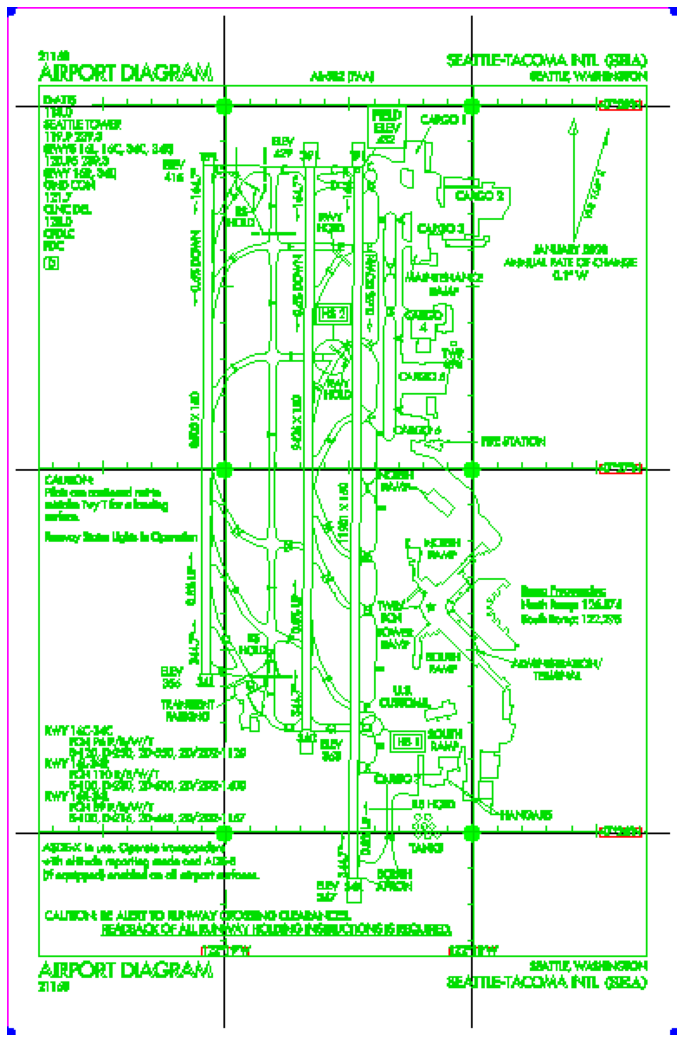

100%|██████████| 1/1 [00:52<00:00, 52.35s/it]


In [ ]:
import glob
import ntpath

passed_pdfs=[]
failed_pdfs=[]
for  pdf_name in  tqdm(glob.glob(r'/content/charts'+'/*.PDF')):  
  try:
    process_pdf(pdf_name)
    passed_pdfs.append(pdf_name)
  except:
    failed_pdfs.append(pdf_name)
    pass      

In [ ]:
!rm /content/charts/*

In [ ]:
failed_pdfs

In [ ]:
%matplotlib inline

In [ ]:
df=gpd.read_file(r'/content/charts/KMSP_polys.geojson')
df.explore()

In [ ]:
!zip -r charts.zip  /content/charts/*geojson

  adding: content/charts/KMSP.geojson (deflated 52%)
  adding: content/charts/KMSP_polys.geojson (deflated 75%)
